## 음성 인식 Kaggle 챌린지를 위한 가벼운 코드입니다. 

참고삼아 진행해보시고 좋은 결과를 얻으시길 바랍니다. 

In [1]:
import tensorflow as tf
import numpy as np
import random
import time
import os
import itertools
import matplotlib.pyplot as plt

tf.set_random_seed(0)

## 첫 번째 과정 - 경로 지정 <br  />

1.npy로 변환한 train 폴더경로 <br  />
2.npy로 변환한 test 폴더 경로 <br  />
2.label.csv 경로 <br  />
3.결과를 저장할 경로

In [2]:
train_dir_path = "C:/trainnpy/audio"
test_dir_path = "C:/testnpy/audio"
label_file_path = "label.csv"
saveDir = "D:/kaggle/"

## 두 번째 과정 - train/validation/test 7:1:2나누기 <br  />

파일을 읽어 분리하는 부분

In [3]:
def search(dirname):
    filelist = []
    filenames = os.listdir(dirname)
    for filename in filenames:
        full_filename = os.path.join(dirname, filename)
        filelist.append(full_filename.replace('\\', '/'))
    return filelist

In [4]:
train_dirs = search(train_dir_path)
trainX = []
validationX = []
testX = []
nclass = len(train_dirs)
print("클래스의 개수 : ",nclass)

클래스의 개수 :  30


In [5]:
random.seed(0)
for class_dir in train_dirs:
    audio_dirs = search(class_dir)
    naudio = len(audio_dirs)
    ntrain = int(naudio*0.7)
    nvalidation = int(naudio*0.1)
    ntest = int(naudio-ntrain-nvalidation)
    random.shuffle(audio_dirs)
    for i in range(naudio):
        if i <ntrain:
            trainX.append(audio_dirs[i])
        elif i>=ntrain and i<(ntrain+nvalidation):
            validationX.append(audio_dirs[i])
        elif i>=(ntrain + nvalidation):
                        testX.append(audio_dirs[i])

나중을 위해 파일 경로를 저장 

In [6]:
np.savetxt(saveDir+"validationX.csv",validationX, fmt='%s',delimiter=',')
np.savetxt(saveDir+"testX.csv",testX, fmt='%s',delimiter=',')

In [7]:
print("=== 분류 결과 ===")
total_train_num = len(trainX)
total_validation_num = len(validationX)
total_testX_num = len(testX)
print("The number of train samples : ",total_train_num)
print("The number of validation samples : ",total_validation_num)
print("The number of test1X samples : ",total_testX_num)
print()

The number of train samples :  45292
The number of validation samples :  6459
The number of test1X samples :  12970



## npy로 된 audio파일은 다음과 같이 되어 있습니다. <br  />

전처리가 필요합니다. 

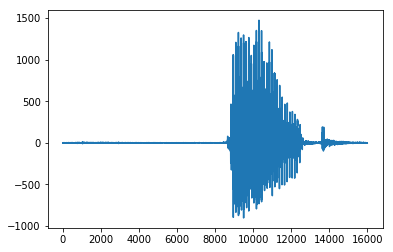

In [8]:
data = np.load(trainX[0])
plt.plot(data)
plt.show()

## 세 번째 과정 - 라벨을 만듭니다. <br  />

In [9]:
keys=[]
labels=[]
for line in open(label_file_path):
    fields = line.rstrip().split(',')
    keys.append(fields[0])
    label = int(fields[1])
    labels.append(label)

label_dict = dict(itertools.zip_longest(keys,labels))

## mini batch를 만들기 위한 함수들입니다. <br  />

In [10]:
def zero_pad(A, max_length):
    arr = np.zeros(max_length)
    arr[:len(A)] = A
    return arr

In [11]:
def make_batch(data, label_dict):
    max_length = 16000
    nbatch = len(data)
    
    for i in range(nbatch):
        a = data[i]
        temp_label = a.split('/')[-2]
        temp_label = np.array([[label_dict[temp_label]]])
        temp_feature = np.load(a)
        temp_feature = zero_pad(temp_feature,max_length)
        temp_feature = np.expand_dims(temp_feature,axis=0)
        temp_feature = np.expand_dims(temp_feature,axis=2)
        if i == 0:
            features = temp_feature
            labels = temp_label
        else:
            features = np.append(features, temp_feature, axis=0)
            labels = np.append(labels, temp_label,axis=0)
    return features, labels

## 네 번째 과정 - 모델을 만듭니다. <br  />

In [12]:
class Model:
    def __init__(self,sess,name):
        self.sess = sess
        self.name = name
        self._build_net()
        
    def length(self, sequence):
        used = tf.sign(tf.reduce_max(tf.abs(sequence), 2))
        length = tf.reduce_sum(used, 1)
        length = tf.cast(length, tf.int32)
        return length
    
    def _last_relevant(self, output, length):
        batch_size = tf.shape(output)[0]
        max_length = tf.shape(output)[1]
        output_size = tf.shape(output)[2]
        index = tf.range(0, batch_size) * max_length + (length - 1)
        flat = tf.reshape(output, [-1, output_size])
        relevant = tf.gather(flat, index)
        return relevant
    
    def _build_net(self):
        with tf.variable_scope(self.name):
            self.X = tf.placeholder(tf.float32, [None, None, 1], name='X')
            self.Y = tf.placeholder(tf.int32, [None, 1], name='Y')
            self.learning_rate = tf.placeholder(tf.float32,name = 'learning_rate')
            self.Y_one_hot = tf.reshape(tf.one_hot(self.Y, 30), [-1, 30])
            len_X=self.length(self.X)

            cell = tf.contrib.rnn.LSTMCell(num_units = 100, initializer = tf.glorot_uniform_initializer(seed=0), state_is_tuple=True)
            outputs, _states = tf.nn.dynamic_rnn(cell, self.X, dtype=tf.float32, sequence_length=len_X)
            last = self._last_relevant(outputs, len_X)

            W1 = tf.Variable(tf.truncated_normal([100, 30], seed = 0, stddev=0.01),name='W1')
            b1 = tf.Variable(tf.constant(0.1, shape=[30]),name='b1')

            self.logits = tf.add(tf.matmul(last,W1),b1,name='logits')
            self.hypothesis = tf.nn.softmax(self.logits, name='hypothesis')
            self.cost = -tf.reduce_mean(self.Y_one_hot * tf.log(self.hypothesis), name='cost')
            self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)

            self.prediction = tf.argmax(self.hypothesis, 1)
            self.correct_prediction = tf.equal(self.prediction, tf.argmax(self.Y_one_hot, 1))
            self.accuracy = tf.reduce_sum(tf.cast(self.correct_prediction, tf.float32), name='accuracy')

    def prediction(self, x_test):
        return self.sess.run(self.prediction, feed_dict = {self.X:x_test})

    def train(self, x_train, y_train, u):
        return sess.run([self.accuracy, self.cost, self.optimizer], feed_dict={self.X: x_train, self.Y: y_train, self.learning_rate: u})


## 다섯 번째 과정 - 실행 <br/>

In [ ]:
sess = tf.Session()
model_name = 'model1'
m = Model(sess, model_name)

d:\python35\lib\site-packages\tensorflow\python\ops\gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


### cpu버전에서 진행하였기 때문에 
### 간단한 테스트를 위해 total_epochs = 1
### batch_size = 10

In [ ]:
init = tf.global_variables_initializer()
sess.run(init)

total_epochs = 1
batch_size = 10
total_step = int(total_train_num/batch_size)
train_size = total_step*batch_size
init_learning_rate = 0.001
u = init_learning_rate 
trainX = np.array(trainX)
print("Learning start")
print("total_step : ",total_step)
for epoch in range(total_epochs):
    mask = np.random.permutation(total_train_num)
    trainX = trainX[mask]
    avg_acc = 0
    avg_cost = 0
    for step in range(total_step):
        data = trainX[step*batch_size:(step+1)*batch_size]
        batchX, batchY = make_batch(data, label_dict)
        a, c, _ = m.train(batchX, batchY, u)
        avg_acc += a
        avg_cost +=c
        if step%100 == 0:
            print("Step : {}, accuracy : {:.2%}, cost : {:.6f}".format(step, a/batch_size, c))
    avg_acc = avg_acc / (total_step*batch_size)
    avg_cost = avg_cost / total_step
    print("Epoch : {}, accuracy : {:.2%}, cost : {:.6f}".format(step, avg_acc, avg_cost))

Learning start
total_step :  4529
Step : 0, accuracy : 0.00%, cost : 0.113262


## test와 validation은 각자!!
## 좋은 결과를 바랍니다. 
## by Eul